In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import glob,os
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection
from sklearn.preprocessing import LabelEncoder

In [2]:
fault_loc = (os.getcwd()+'/Fault monitoring project/New-Machine_Experimental Data/MachineNewData/Faulty').replace('\\','/')
healthy_loc = (os.getcwd()+'/Fault monitoring project/New-Machine_Experimental Data/MachineNewData/Healthy').replace('\\','/')

In [3]:
feats = ['mean','std','skewness','kurtosis','max','min', 'crestF', 'RMS', 'pk-pk', 'shapeFactor','impulseFactor','MarginFactor']

def features(i):
    return [np.mean(i),np.std(i),skew(i),kurtosis(i),np.max(i),np.min(i), max(i)/np.sqrt(np.mean(i**2)),np.sqrt(np.mean(i**2)),max(i)-min(i),
               np.sqrt(np.mean(i**2))/np.mean(abs(i)), max(i)/np.mean(abs(i)), max(i)/np.mean(abs(i))**2]

In [4]:
%%time
i1=[]   
i2=[]
i3=[]

for i,file in enumerate(glob.glob(fault_loc+"/*/*/*/*.lvm")):
    data = open(file).read()
    i = []
    for instance in data.split("Comment\n")[1].split('\n')[:-2]:
        i.append(instance.split('\t')[3])
        
    i = np.array(i,dtype=np.float32)
    
    for split in np.split(i,10):
        if('I1' in file):
            i1.append(features(split))
        elif('I2' in file):
            i2.append(features(split))
        elif('I3' in file):
            i3.append(features(split))
        
i1 = pd.DataFrame(i1, columns=feats)
i2 = pd.DataFrame(i2, columns=feats)
i3 = pd.DataFrame(i3, columns=feats)

i1['current'] = 'i1'
i2['current'] = 'i2'
i3['current'] = 'i3'

data_fault = pd.concat([i1,i2,i3]).reset_index(drop=True)
data_fault['type'] = 'faulty'

Wall time: 14.8 s


In [5]:
%%time
i1=[]   
i2=[]
i3=[]

for i,file in enumerate(glob.glob(healthy_loc+"/*/*/*.lvm")):
    data = open(file).read()
    i = []
    for instance in data.split("Comment\n")[1].split('\n')[:-2]:
        i.append(instance.split('\t')[3])
        
    i = np.array(i,dtype=np.float32)
    
    for split in np.split(i,10):
        if('I1' in file):
            i1.append(features(split))
        elif('I2' in file):
            i2.append(features(split))
        elif('I3' in file):
            i3.append(features(split))


i1 = pd.DataFrame(i1, columns=feats)
i2 = pd.DataFrame(i2, columns=feats)
i3 = pd.DataFrame(i3, columns=feats)

i1['current'] = 'i1'
i2['current'] = 'i2'
i3['current'] = 'i3'

data_health = pd.concat([i1,i2,i3]).reset_index(drop=True)
data_health['type'] = 'healthy'

Wall time: 7.11 s


In [6]:
data = (pd.concat([data_fault,data_health]).sample(frac=1,random_state=42)).reset_index(drop=True)

otp_ = data.apply(LabelEncoder().fit_transform).iloc[:,-1]
inp_ = pd.concat([data.iloc[:,:-2],pd.get_dummies(data['current'])],axis=1)

### Feature Selection

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif,mutual_info_classif
best_feats = 3

selector = SelectKBest(f_classif, k=best_feats)
selector.fit(inp_, otp_)
# Get columns to keep
cols = selector.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
inp = inp_.iloc[:,cols]

In [8]:
inp.head()

,std,skewness,RMS
0,0.129561,-0.043959,0.132929
1,0.107852,0.041797,0.110802
2,0.296502,0.006164,0.297696
3,0.422635,0.003546,0.422958
4,0.129919,-0.019842,0.130944


In [9]:
inp_.head()

,mean,std,skewness,kurtosis,max,min,crestF,RMS,pk-pk,shapeFactor,impulseFactor,MarginFactor,i1,i2,i3
0,0.029733,0.129561,-0.043959,-1.195863,0.286866,-0.265517,2.158043,0.132929,0.552383,1.152769,2.487725,21.573744,0,1,0
1,0.025396,0.107852,0.041797,-1.526541,0.186538,-0.125538,1.683525,0.110802,0.312076,1.122846,1.890340,19.156342,1,0,0
2,0.026637,0.296502,0.006164,-1.392611,0.475467,-0.425150,1.597157,0.297696,0.900617,1.132870,1.809372,6.885501,1,0,0
3,0.016536,0.422635,0.003546,-1.456531,0.633526,-0.611766,1.497845,0.422958,1.245292,1.119522,1.676871,4.438485,0,0,1
4,0.016356,0.129919,-0.019842,-1.508510,0.209343,-0.174777,1.598719,0.130944,0.384120,1.112924,1.779253,15.122273,0,0,1


C:\Users\Tarunbir Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


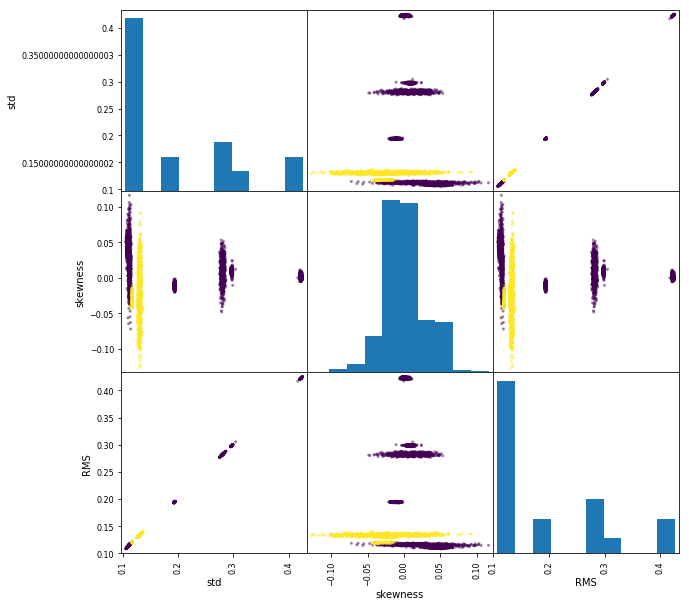

In [10]:
%matplotlib inline
#grr = pd.scatter_matrix(data[data['current']=='i1'].iloc[:,:-1], c = otp[data[data['current']=='i1'].index], figsize=(10,10))
grr = pd.scatter_matrix(inp, c = otp_, figsize=(10,10))
 

In [11]:
inp_train = inp.iloc[:int(0.8*inp.shape[0]),:]
otp_train = otp_[:int(0.8*inp.shape[0])]
inp_test = inp.iloc[int(0.8*inp.shape[0]):,:]
otp_test = otp_[int(0.8*inp.shape[0]):]

### Artificial Neural Network

Train on 7200 samples, validate on 1800 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
7200/7200 [==============================] - 2s 299us/sample - loss: 0.3022 - acc: 0.8737 - val_loss: 0.1939 - val_acc: 0.9350
Epoch 2/3
7200/7200 [==============================] - 2s 220us/sample - loss: 0.1928 - acc: 0.9379 - val_loss: 0.1876 - val_acc: 0.9300
Epoch 3/3
7200/7200 [==============================] - 2s 213us/sample - loss: 0.1789 - acc: 0.9383 - val_loss: 0.1723 - val_acc: 0.9378


Text(0.5, 1.0, 'Accuracy')

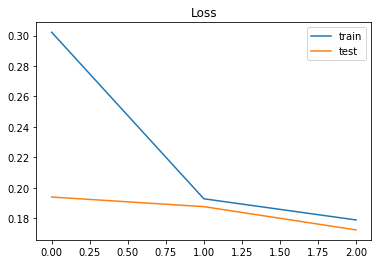

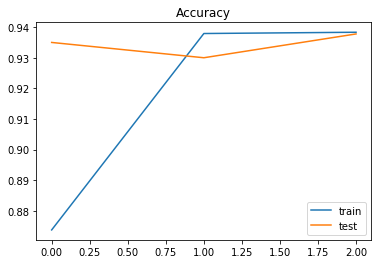

In [13]:
import tensorflow.keras as k
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

model = k.Sequential()
model.add(k.layers.Dense(100, input_dim=best_feats, kernel_initializer='normal', activation='relu'))
model.add(k.layers.Dense(2000, kernel_initializer='normal', activation='relu'))
model.add(k.layers.Dense(1, kernel_initializer='normal', activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(inp_train,otp_train,validation_data=(inp_test,otp_test),epochs=3)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'])
plt.title('Loss')

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','test'])
plt.title('Accuracy')

In [14]:
pred = model.predict(inp_test)
pred = (pred>0.5)*1
print("\nConfusion Matrix : \n",confusion_matrix(otp_test,pred))
print(classification_report(otp_test,pred))


Confusion Matrix : 
 [[1143   59]
 [  53  545]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1202
           1       0.90      0.91      0.91       598

   micro avg       0.94      0.94      0.94      1800
   macro avg       0.93      0.93      0.93      1800
weighted avg       0.94      0.94      0.94      1800



### Support Vector Machine

In [15]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto',kernel='rbf')
svm_clf.fit(inp_train,otp_train)

svm_pred = svm_clf.predict(inp_test)

print("Test accuracy : ",sum([int(y==t) for y,t in zip(svm_pred,otp_test)])/len(otp_test))
print("\nConfusion Matrix : \n",confusion_matrix(otp_test,svm_pred))
print(classification_report(otp_test,svm_pred))

Test accuracy :  0.9294444444444444

Confusion Matrix : 
 [[1126   76]
 [  51  547]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1202
           1       0.88      0.91      0.90       598

   micro avg       0.93      0.93      0.93      1800
   macro avg       0.92      0.93      0.92      1800
weighted avg       0.93      0.93      0.93      1800



### Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc_clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rfc_clf.fit(inp_train,otp_train)

rfc_pred = rfc_clf.predict(inp_test)

print("Test accuracy : ",sum([int(y==t) for y,t in zip(rfc_pred,otp_test)])/len(otp_test))
print("\nConfusion Matrix : \n",confusion_matrix(otp_test,rfc_pred))
print(classification_report(otp_test,rfc_pred))

Test accuracy :  0.9994444444444445

Confusion Matrix : 
 [[1201    1]
 [   0  598]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1202
           1       1.00      1.00      1.00       598

   micro avg       1.00      1.00      1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800

